In [1]:
library(glmnet)
library(ggplot2)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13



# Ridge Regularization

In [2]:
ridge_train <- read.csv("../../datasets/ridge_train.csv")
ridge_test <- read.csv("../../datasets/ridge_test.csv")
head(ridge_train)

Size,Price
1700,286500
1701,549000
1662,249000
1852,550000
1320,170000
1456,225000


In [3]:
# Building a 10th order polynomial
poly_10 <- lm(Price~poly(Size,10),ridge_train)
train_matrix <- poly(ridge_train$Size,10)
test_matrix <- poly(ridge_test$Size,10)

In [4]:
# --------- Plot function----------
plot_func <- function(pre_val, title){
  ggplot() + 
    geom_line(aes(x = ridge_train$Size, y = pre_val, col = 'Ridge (L2)'), size = 1.2) +
    geom_line(aes(x = ridge_train$Size, y = fitted(poly_10), col = 'Polynomial'), size = 1.2) +
    geom_point(aes(x = ridge_train$Size, y = ridge_train$Price), size = 1.5) +
    labs(col = 'Regression Type') +
    scale_color_manual(values = c("Ridge (L2)" = "darkolivegreen3",
                                  "Polynomial" = "lightcoral")) +
    title +
    xlab("Size") + ylab("Price") +
    theme_bw() +
    theme(panel.grid.major = element_line(colour = "white"),
          axis.text = element_text(size = 10),
          axis.title = element_text(size = 12),
          plot.title = element_text(hjust = 0.5),
          legend.title = element_text(face = 'bold'))
}

In [5]:
# Model at lambda = 0
lam_0 = glmnet(train_matrix, ridge_train$Price, alpha = 0)
lam_0_pre <- predict(lam_0, 
                     s = 0,             # Value for penalty parameter lambda
                     train_matrix)

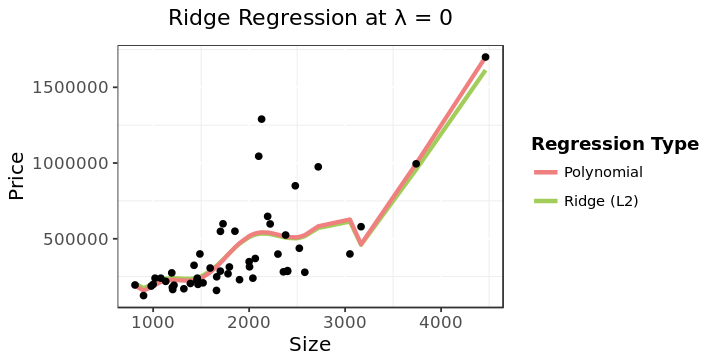

In [6]:
title <- ggtitle(expression(paste("Ridge Regression at ", lambda," = ", 0))) 
options(repr.plot.width=6, repr.plot.height=3)
plot_func(lam_0_pre, title)

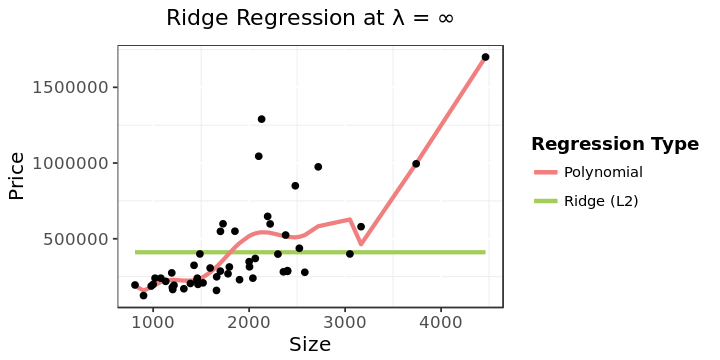

In [7]:
# Model at lambda = Inf (approx)
lam_inf = glmnet(train_matrix, ridge_train$Price, alpha = 0)
lam_inf_pre <- predict(lam_inf, s = 9999999999, train_matrix)
title <- ggtitle(expression(paste("Ridge Regression at ", lambda," = ", infinity))) 
plot_func(lam_inf_pre, title)

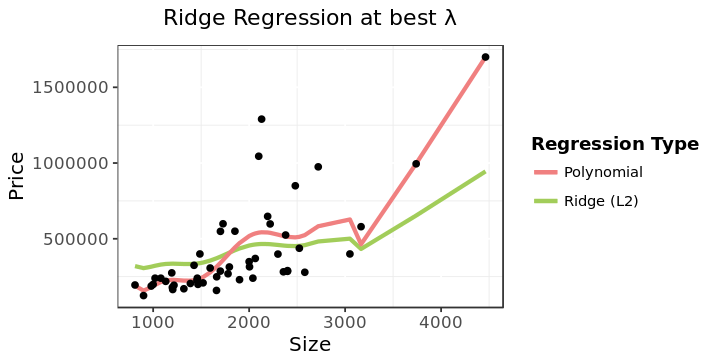

In [8]:
# Model at best lambda
lam_best <- cv.glmnet(train_matrix, ridge_train$Price, alpha = 0)
lam_best_pre <- predict(lam_best,s = lam_best$lambda.min, train_matrix)
title <- ggtitle(expression(paste("Ridge Regression at best ", lambda ))) 
plot_func(lam_best_pre, title)

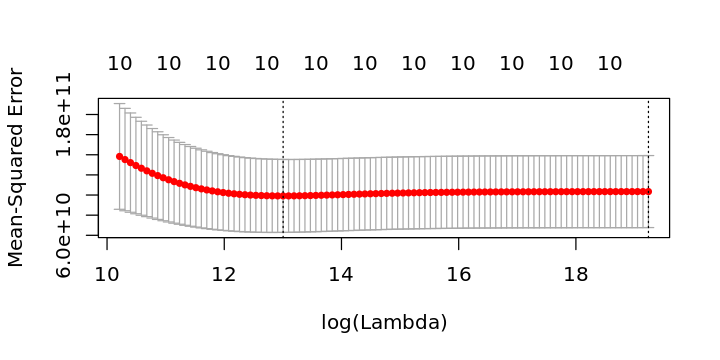

In [9]:
plot(lam_best)

In [10]:
# Original coefs
poly_10$coefficients

(Intercept)  poly(Size, 10)1  poly(Size, 10)2  poly(Size, 10)3 
       411109.00       1600857.35        423859.80        344984.79 
 poly(Size, 10)4  poly(Size, 10)5  poly(Size, 10)6  poly(Size, 10)7 
       286933.31       -204538.20       -179615.92         85769.62 
 poly(Size, 10)8  poly(Size, 10)9 poly(Size, 10)10 
       -20713.58       -211008.61        -43763.37

In [11]:
#### Regularized coefs
# Finding Coefficients of "Size" against lambda.min
cv_model <- glmnet(train_matrix, ridge_train$Price, alpha = 0,lambda = lam_best$lambda.min)
print(cv_model$a0)
cv_model$beta

    s0 
411109 


10 x 1 sparse Matrix of class "dgCMatrix"
           s0
1  663132.375
2  175577.890
3  142905.041
4  118858.041
5  -84727.037
6  -74403.340
7   35528.846
8   -8580.305
9  -87407.312
10 -18128.352

In [12]:
# RMSE calculations
train_model <- predict(lam_best, s = lam_best$lambda.min, train_matrix)
rmse_train <- sqrt(mean((train_model - ridge_train$Price)^2))
cat("Regularized RMSE train", rmse_train, end="\n")

test_model <- predict(lam_best, s = lam_best$lambda.min, test_matrix)
rmse_test <- sqrt(mean((test_model - ridge_test$Price)^2))
cat("Regularized RMSE test", rmse_test, end="\n")

rmse_train_orig <- sqrt(mean((poly_10$residuals)^2))
cat("Original RMSE train", rmse_train_orig, end="\n")

rmse_test_orig <- sqrt(mean((predict(poly_10,data.frame(Size = ridge_test$Size)) - ridge_test$Price)^2))
cat("Original RMSE test", rmse_test_orig)

Regularized RMSE train 241691 
Regularized RMSE test 206321 
Original RMSE train 193216.9 
Original RMSE test 133415359

# Lasso Regularization

In [13]:
lasso_data <- read.csv("../../datasets/lasso.csv")
names(lasso_data)

[1] "num_critic_for_reviews"    "duration"                 
 [3] "director_facebook_likes"   "actor_3_facebook_likes"   
 [5] "actor_1_facebook_likes"    "gross"                    
 [7] "num_voted_users"           "cast_total_facebook_likes"
 [9] "facenumber_in_poster"      "num_user_for_reviews"     
[11] "budget"                    "actor_2_facebook_likes"   
[13] "aspect_ratio"              "movie_facebook_likes"     
[15] "imdb_score"

In [14]:
# Splitting Original data into training and testing parts
smp_size <- floor(0.7 * nrow(lasso_data))
set.seed(42)
train_ind <- sample(seq_len(nrow(lasso_data)), size = smp_size)
train_data <- lasso_data[train_ind, ]
test_data <- lasso_data[-train_ind, ]

In [15]:
# Applying linear regression

model_lr <- lm(formula = imdb_score~., data = train_data)
model_lr


Call:
lm(formula = imdb_score ~ ., data = train_data)

Coefficients:
              (Intercept)     num_critic_for_reviews  
                5.448e+00                  1.162e-03  
                 duration    director_facebook_likes  
                6.794e-03                  6.471e-06  
   actor_3_facebook_likes     actor_1_facebook_likes  
                1.059e-04                  9.953e-05  
                    gross            num_voted_users  
               -2.370e-09                  4.114e-06  
cast_total_facebook_likes       facenumber_in_poster  
               -9.966e-05                 -3.669e-02  
     num_user_for_reviews                     budget  
               -4.562e-04                 -9.542e-11  
   actor_2_facebook_likes               aspect_ratio  
                1.005e-04                  6.339e-02  
     movie_facebook_likes  
               -8.741e-07  


In [16]:
# Applying L1 regularization

l1_mat <- as.matrix(train_data[-15])
model_l1 = cv.glmnet(l1_mat,
                     train_data$imdb_score,
                     alpha = 1)

In [17]:
# Coefficients
best_pred_coef <- predict(model_l1,s = model_l1$lambda.min,
                          l1_mat,type = "coefficients") 
best_pred_coef

15 x 1 sparse Matrix of class "dgCMatrix"
                                     1
(Intercept)               5.900897e+00
num_critic_for_reviews    8.062270e-05
duration                  3.315895e-03
director_facebook_likes   .           
actor_3_facebook_likes    .           
actor_1_facebook_likes    .           
gross                     .           
num_voted_users           2.376529e-06
cast_total_facebook_likes .           
facenumber_in_poster      .           
num_user_for_reviews      .           
budget                    .           
actor_2_facebook_likes    .           
aspect_ratio              .           
movie_facebook_likes      .           

In [18]:
# RMSE calcs
l1_pre = as.matrix(test_data[-15])

pred_train <- predict(model_l1,s = model_l1$lambda.min,l1_mat)
pred_test <- predict(model_l1,s = model_l1$lambda.min,l1_pre)

rmse_train_l1 <- sqrt(mean((pred_train - train_data$imdb_score)^2))
cat("Regularized RMSE train", rmse_train_l1, end = "\n")

rmse_test_l1 <- sqrt(mean((pred_test - test_data$imdb_score)^2))
cat("Regularized RMSE test", rmse_test_l1, end = "\n")

rmse_train_lr <- sqrt(mean((model_lr$residuals)^2))
cat("Unregularized RMSE train", rmse_train_lr, end = "\n")

rmse_test_lr <- sqrt(mean((predict(model_lr,test_data) - test_data$imdb_score)^2))
cat("Unregularized RMSE test", rmse_test_lr, end = "\n")

Regularized RMSE train 1.003375 
Regularized RMSE test 1.063083 
Unregularized RMSE train 0.9649056 
Unregularized RMSE test 1.0331 


In [19]:
# RMSEs remain the almost same even though in L1 we have removed many predictors.


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract

The following object is masked from ‘package:Matrix’:

    expand



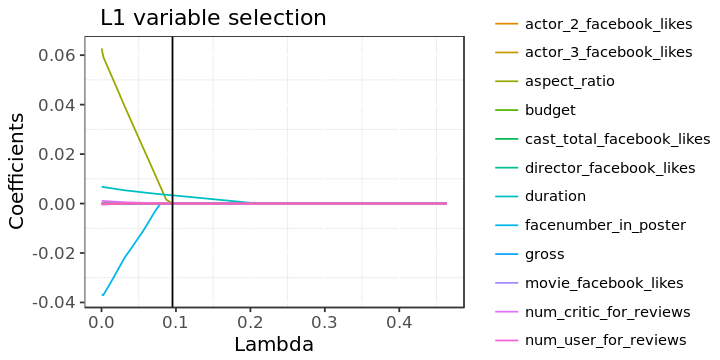

In [20]:
# Visualization of Coefficients with lambda
library(magrittr)
library(tidyr)
lamb_all <- predict(model_l1,s = model_l1$lambda,l1_mat,type = "coefficients") 
df <- cbind(as.data.frame(as.matrix(t(lamb_all))),as.data.frame(model_l1$lambda))
l1 = df[,c(-1)] # Excluding the Intercept
colnames(l1)[15] <- 'lambda'

l1 <- l1 %>%
  gather(column,value,-lambda)


ggplot(l1) + geom_line(aes(lambda,value, col = column)) + 
  geom_vline(xintercept = model_l1$lambda.min) +
  ggtitle("L1 variable selection") + xlab("Lambda") + ylab("Coefficients") +
  theme_bw() +
  theme(panel.grid.major = element_line(colour = "white"),
        axis.text = element_text(size = 10),
        axis.title = element_text(size = 12),
        plot.title = element_text(hjust = 0.1),
        legend.title = element_text(face = 'bold'))